# Aggregate proteomic data across studies

For best results, first run the [IdentifierUpdates_Proteomics](../curation/IdentifierUpdates_Proteomics.ipynb) notebook first to remove old/obsolete accessions and map to current UniProt database. 
## Load protein table

Run the  notebook first to create the protein table.
Note: Requires internet connection to download information from the UniProt.

## Setup
### Import packages

In [1]:
from pathlib import Path
from warnings import warn

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from rbc_gem_utils import (ANNOTATION_PATH, DATABASE_PATH, EXTERNAL_PATH,
                           INTERIM_PATH, PROCESSED_PATH, ROOT_PATH,
                           check_version, show_versions)
from rbc_gem_utils.database.uniprot import (UNIPROT_VERSION_EXPECTED,
                                            get_version_UniProt, query_UniProt)

# Display versions of last time notebook ran and worked
show_versions()
plt.rcParams["font.family"] = "Arial"


Package Information
-------------------
rbc-gem-utils 0.0.1

Dependency Information
----------------------
beautifulsoup4                       4.12.3
bio                                   1.6.2
cobra                                0.29.0
depinfo                               2.2.0
kaleido                               0.2.1
matplotlib                            3.8.2
memote                               0.17.0
networkx                              3.2.1
notebook                              7.0.7
openpyxl                              3.1.2
pandas                                2.2.0
pre-commit                            3.6.0
pyvis                                 0.3.2
rbc-gem-utils[database,network,vis] missing
requests                             2.31.0
scipy                                1.12.0
seaborn                              0.13.2

Build Tools Information
-----------------------
pip        23.3.1
setuptools 68.2.2
wheel      0.41.2

Platform Information
-------------------

## Check UniProt version
If the version does not match the expected version, it is because database has been updated since the last time this code was utilized. 

### Expected UniProt version: 2024_06
* According to [UniProt](https://www.uniprot.org/help/downloads), updates to the database are made every eight weeks. 

In [2]:
version = get_version_UniProt()
if check_version(version, UNIPROT_VERSION_EXPECTED, verbose=True):
    database_dirpath = f"{ROOT_PATH}{DATABASE_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{ANNOTATION_PATH}"
else:
    # Use different directory paths for unexpected behavior
    database_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"
    annotation_dirpath = f"{ROOT_PATH}{INTERIM_PATH}"

Current and expected versions match.


## Load aggregated proteomic data, updated IDs

In [3]:
excel_filepath_processed = (
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomics_aggregated.xlsx"
)
overwrite = True
results_path = Path(f"{ROOT_PATH}{PROCESSED_PATH}/AllProteomicEvidence")
results_path.mkdir(exist_ok=True, parents=True)

### Load table of contents

In [4]:
df_contents = pd.read_excel(
    excel_filepath_processed, sheet_name="Table of Contents", dtype=str
).fillna("")
df_contents

,PubMed/Sheet Name,ID type,Year,Publication,Notes
0,12362340,UniProt,2002,"Low TY, Seow TK, Chung MC. Separation of human...",84 UniProt --> 79 UniProt 2024_06
1,14963112,UniProt,2004,"Kakhniashvili DG, Bulla LA Jr, Goodman SR. The...",183 GI;128 Obsolete;7 UniParc;66 UniProt --> ...
2,16861337,UniProt,2006,"Pasini EM, Kirkegaard M, Mortensen P, Lutz HU,...",590 IPI;197 Obsolete;0 UniParc;393 UniProt -->...
3,18399644,UniProt,2008,"Simó C, Bachi A, Cattaneo A, Guerrier L, Forti...",153 IPI;42 Obsolete;0 UniParc;111 UniProt --> ...
4,18494517,UniProt,2008,"Ringrose JH, van Solinge WW, Mohammed S, O'Fla...",699 IPI;310 Obsolete;0 UniParc;389 UniProt -->...
5,18614565,UniProt,2008,"Roux-Dalvai F, Gonzalez de Peredo A, Simó C, G...",1577 IPI;364 Obsolete;0 UniParc;1214 UniProt -...
6,19778645,UniProt,2009,"van Gestel RA, van Solinge WW, van der Toorn H...",561 GI;180 Obsolete;22 UniParc;426 UniProt -->...
7,22157974,UniProt,2011,"D'Amici GM, Rinalducci S, Zolla L. Depletion o...",134 GI;214 Obsolete;0 UniParc;44 UniProt --> ...
8,22954596,UniProt,2012,"Pesciotta EN, Sriswasdi S, Tang HY, Mason PJ, ...",831 UniProt --> 765 UniProt 2024_06
9,23781972,UniProt,2013,"Pallotta V, D'Alessandro A, Rinalducci S, Zoll...",140 GI;47 Obsolete;5 UniParc;118 UniProt --> ...


### Aggregate proteins into table

In [5]:
all_sheet_dfs = {"Table of Contents": df_contents}

index_name = "Uniprot"
df_proteins_aggregated = pd.DataFrame([], columns=[index_name])
for _, (sheet_name, id_type) in df_contents[
    ["PubMed/Sheet Name", "ID type"]
].iterrows():
    if id_type != "UniProt":
        warn("Can only utilize UniProt IDs for final aggregation")
        continue
    df = pd.read_excel(excel_filepath_processed, sheet_name=sheet_name, usecols=[0])
    df.columns = [sheet_name]
    df[index_name] = df[sheet_name]
    all_sheet_dfs[sheet_name] = df.copy()
    df_proteins_aggregated = df_proteins_aggregated.merge(
        df, left_on=index_name, right_on=index_name, how="outer"
    )
df_proteins_aggregated = (
    df_proteins_aggregated.drop_duplicates().set_index(index_name).notna()
)
df_proteins_aggregated.columns.name = "pubmed"
# MIRIAM compliant
df_proteins_aggregated = df_proteins_aggregated.rename(
    {col: f"pubmed:{col}" for col in df_proteins_aggregated.columns}, axis=1
)
df_unreviewed_proteins = df_proteins_aggregated.copy()
df_unreviewed_proteins

pubmed,pubmed:12362340,pubmed:14963112,pubmed:16861337,pubmed:18399644,pubmed:18494517,pubmed:18614565,pubmed:19778645,pubmed:22157974,pubmed:22954596,pubmed:23781972,...,pubmed:31552303,pubmed:33103907,pubmed:33341364,pubmed:33806028,pubmed:35858567,pubmed:36346805,pubmed:37760001,pubmed:37942280,pubmed:38147558,pubmed:38964323
Uniprot,,,,,,,,,,,,,,,,,,,,,
A0A024QZ42,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024QZ64,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R1A3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
A0A024R4T4,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
A0A024R571,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X6RA14,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
X6RAJ1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
X6RCK5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### Query UniProt, keep reviewed proteins

In [6]:
# Extract all relevant information for now and save
query_parameters = {
    "query": " && ".join(
        [
            "(reviewed:true)",
            "(organism_id:9606)",  # Homo sapiens (Human)
        ]
    ),
    "format": "tsv",
    "size": 500,
    "compressed": True,
    "fields": ",".join(
        [
            "reviewed",
            "accession",
            "gene_primary",
        ]
    ),
}

df_results, uniparc, failed_ids, obselete_counts = query_UniProt(
    list(df_unreviewed_proteins.index),
    query_parameters=query_parameters,
    from_db="UniProtKB",
    to_db="UniProtKB",
    return_failed=True,
)

df_results = df_results[df_results["Reviewed"] == "reviewed"].drop_duplicates()
df_results

Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Retrying in 3s
Fetched: 500 / 4695
Fetched: 1000 / 4695
Fetched: 1500 / 4695
Fetched: 2000 / 4695
Fetched: 2500 / 4695
Fetched: 3000 / 4695
Fetched: 3500 / 4695
Fetched: 4000 / 4695
Fetched: 4500 / 4695


Number of failed query IDs : 1482


Fetched: 4695 / 4695


,From,Reviewed,Entry,Gene Names (primary)
0,A0A024RBG1,reviewed,A0A024RBG1,NUDT4B
1,A0A075B6H7,reviewed,A0A075B6H7,IGKV3-7
2,A0A075B6H9,reviewed,A0A075B6H9,IGLV4-69
3,A0A075B6I0,reviewed,A0A075B6I0,IGLV8-61
4,A0A075B6I9,reviewed,A0A075B6I9,IGLV7-46
...,...,...,...,...
4690,Q9Y6W3,reviewed,Q9Y6W3,CAPN7
4691,Q9Y6W5,reviewed,Q9Y6W5,WASF2
4692,Q9Y6X4,reviewed,Q9Y6X4,FAM169A
4693,Q9Y6X8,reviewed,Q9Y6X8,ZHX2


In [7]:
df_reviewed_proteins = df_unreviewed_proteins.loc[df_results["Entry"].values]
df_reviewed_proteins = df_reviewed_proteins.astype(int)
df_reviewed_proteins = df_reviewed_proteins.loc[
    df_reviewed_proteins.sum(axis=1).sort_values(ascending=False).index.values
]
df_reviewed_proteins

pubmed,pubmed:12362340,pubmed:14963112,pubmed:16861337,pubmed:18399644,pubmed:18494517,pubmed:18614565,pubmed:19778645,pubmed:22157974,pubmed:22954596,pubmed:23781972,...,pubmed:31552303,pubmed:33103907,pubmed:33341364,pubmed:33806028,pubmed:35858567,pubmed:36346805,pubmed:37760001,pubmed:37942280,pubmed:38147558,pubmed:38964323
Uniprot,,,,,,,,,,,,,,,,,,,,,
P04406,1,1,1,1,1,1,1,0,1,1,...,0,1,1,1,1,1,1,1,1,1
P11142,1,1,1,1,1,1,0,0,1,1,...,0,1,1,1,1,1,1,1,1,1
P27105,1,1,1,1,0,1,1,0,1,0,...,1,1,1,1,1,1,1,1,1,1
P00915,0,1,1,0,1,1,0,1,1,1,...,0,1,1,1,1,1,1,1,1,1
Q00013,1,1,1,0,1,1,0,0,1,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8NBM8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q8NBI6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Q8NBF6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Export protein table

In [8]:
if overwrite:
    df_reviewed_proteins.to_csv(
        f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
        sep="\t",
        index=True,
    )
else:
    df_reviewed_proteins.to_csv(
        f"{ROOT_PATH}{INTERIM_PATH}/proteomics/proteomic_evidence_table.tsv",
        sep="\t",
        index=True,
    )

## Visualize Protein Table

In [9]:
# Turned into an xlsx where keys are sheet names and values are DataFrames representing the sheet
all_figure_data = {}
imagetype = "png"
transparent = True

### Create proteomic evidence table for figure
#### Sorted by publication year (original)

In [10]:
df_proteins = pd.read_csv(
    f"{ROOT_PATH}{EXTERNAL_PATH}/proteomics/proteomic_evidence_table.tsv",
    sep="\t",
    index_col=0,
)
df_proteins.columns.name = "pubmed"

# Order by number of times a single  protein was detected across studies
# protein_ids_ordered = df_proteins.sum(axis=1).sort_values(ascending=False).index.values
# df_proteins = df_proteins.loc[protein_ids_ordered, :]
# Transport for figure
df_proteins = df_proteins.T
df_proteins

Uniprot,P04406,P11142,P27105,P00915,Q00013,P49721,P52907,P00352,P25787,P69905,...,Q8NC56,P28340,P28799,Q8NBT2,P29466,Q8NBM8,Q8NBI6,Q8NBF6,Q8NB78,A0A024RBG1
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:12362340,1,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:14963112,1,1,1,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:16861337,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18399644,1,1,1,0,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18494517,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:19778645,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:22157974,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
pubmed:22954596,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


### Reordered

In [11]:
# Order by number of proteins detected in a single study
df_proteins_reordered = df_proteins.T.copy()
pubmed_ids_ordered = (
    df_proteins_reordered.sum(axis=0).sort_values(ascending=False).index.values
)
df_proteins_reordered = df_proteins_reordered.loc[:, pubmed_ids_ordered]
df_proteins_reordered = df_proteins_reordered.T
df_proteins_reordered

Uniprot,P04406,P11142,P27105,P00915,Q00013,P49721,P52907,P00352,P25787,P69905,...,Q8NC56,P28340,P28799,Q8NBT2,P29466,Q8NBM8,Q8NBI6,Q8NBF6,Q8NB78,A0A024RBG1
pubmed,,,,,,,,,,,,,,,,,,,,,
pubmed:38964323,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,1,0,0
pubmed:28689405,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,1,1,0,0,0
pubmed:30327373,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,0,0,0
pubmed:28263177,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,1,0,0,0,0,0
pubmed:37942280,1,1,1,1,1,1,1,1,1,1,...,0,1,0,0,0,0,0,0,0,0
pubmed:35858567,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:33806028,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:18614565,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
pubmed:38147558,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1


### Visualization

In [12]:
df_figure_data = df_proteins.copy()
df_figure_data = df_proteins_reordered.copy()
min_count = 0
max_count = 20
fontsize = 12

edgecolor = "black"
edgewidth = 0.5
bar_size = 0.75
as_percentages = True
cmin, cmax = (0.05, 1)

cmap = mpl.colormaps.get_cmap("terrain_r")
no_evidence_color = mpl.colors.to_rgba_array("xkcd:white")

In [13]:
all_figure_data["ProteomicEvidenceAll"] = df_figure_data.copy()


df_value_counts = df_figure_data.sum(axis=0).value_counts().sort_index()
value_counts = df_value_counts[df_value_counts.index <= max_count].to_dict()
value_counts[max(value_counts.keys())] += df_value_counts[
    df_value_counts.index > max_count
].sum()
value_counts = {int(k): v for k, v in value_counts.items()}
df_value_counts = pd.Series(value_counts, name="Total")
id_fix_dict = {max_count: rf"$\geq${str(max_count)}"}
if min_count:
    value_counts = df_value_counts[df_value_counts.index >= min_count].to_dict()
    value_counts[min(value_counts.keys())] += df_value_counts[
        df_value_counts.index < min_count
    ].sum()
    value_counts = {int(k): v for k, v in value_counts.items()}
    id_fix_dict[min_count] = rf"{str(min_count)}$\geq$"

value_counts = {id_fix_dict.get(k, k): v for k, v in value_counts.items()}


df_value_counts = pd.DataFrame.from_dict(
    value_counts, orient="index", columns=["Total"]
)
df_value_counts.index.name = "Proteomic evidence (#studies)"
# Add colormap to table
cmap_dict = dict(
    zip(
        df_value_counts.index, cmap(np.linspace(cmin, cmax, len(df_value_counts.index)))
    )
)

df_value_counts_colors = df_value_counts.copy()
df_value_counts_colors["Colors"] = cmap_dict
df_value_counts_colors = df_value_counts_colors.reindex(
    index=df_value_counts_colors.index[::-1]
)
df_value_counts_colors.index = df_value_counts_colors.index.astype(str)
df_value_counts_colors

,Total,Colors
Proteomic evidence (#studies),,
$\geq$20,118,"[0.2, 0.2, 0.6, 1.0]"
19,68,"[0.13725490196078433, 0.3254901960784314, 0.72..."
18,74,"[0.06928104575163399, 0.46143790849673205, 0.8..."
17,81,"[0.0013071895424836603, 0.5973856209150327, 0...."
16,85,"[0.0, 0.7, 0.7, 1.0]"
15,86,"[0.0, 0.7941176470588236, 0.4176470588235294, ..."
14,87,"[0.19215686274509802, 0.8384313725490197, 0.43..."
13,88,"[0.39607843137254906, 0.8792156862745099, 0.47..."
12,97,"[0.6, 0.92, 0.52, 1.0]"


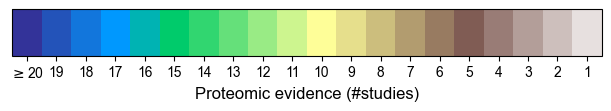

In [14]:
orientation = "horizontal"
figsize = (1 if orientation == "vertical" else 6, 6 if orientation == "vertical" else 1)
fig_colorbar, cbar_ax = plt.subplots(figsize=figsize, layout="constrained")

cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", list(cmap_dict.values()), len(cmap_dict)
)
xticks = list(np.linspace(0, len(cmap_dict) - 1, len(cmap_dict)) + 0.5)
if orientation == "vertical":
    cmap_segmented = cmap_segmented.reversed("legend")
    xticks.reverse()

norm = mpl.colors.BoundaryNorm(
    np.linspace(0, len(cmap_dict), len(cmap_dict) + 1), cmap_segmented.N
)
colorbar = fig_colorbar.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap_segmented),
    cax=cbar_ax,
    orientation=orientation,
    label=df_value_counts_colors.index.name,
)
colorbar.set_ticks(
    xticks, minor=False, labels=df_value_counts_colors.index, fontsize=fontsize - 2
)
colorbar.set_ticks([], minor=True)
cbar_ax.set_xlabel(df_value_counts_colors.index.name, fontdict={"size": fontsize})
fig_colorbar;

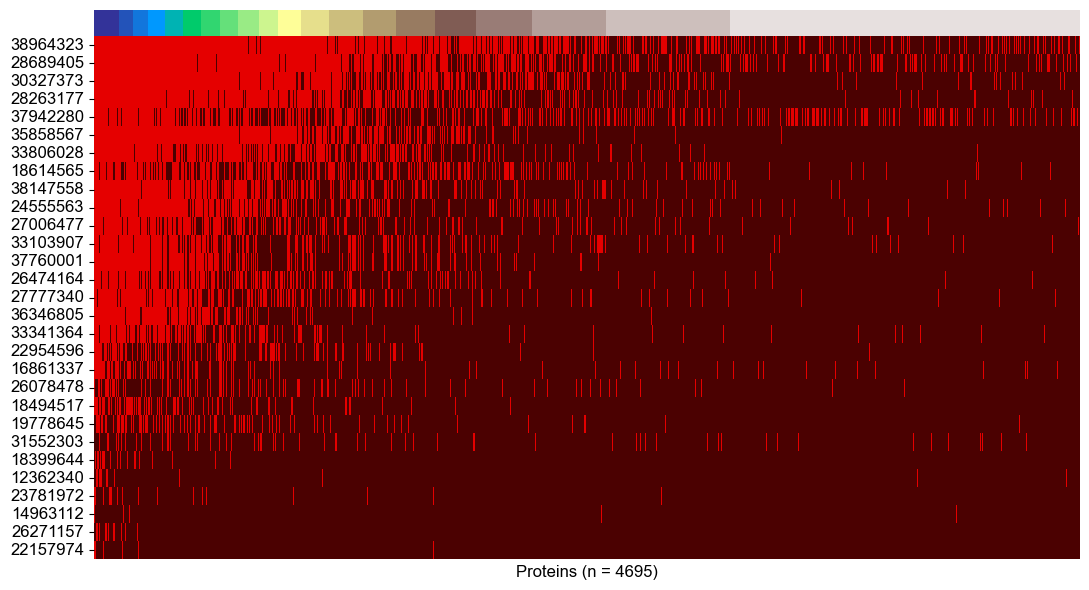

In [15]:
fig = mpl.figure.Figure(figsize=(11, 6))
gs = mpl.gridspec.GridSpec(2, 1, hspace=0, height_ratios=[0.05, 1])

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x > min_count else min_count)

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    np.array([df_proteomic_cmap.values]),
    ax=fig.add_subplot(gs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)


ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(gs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize=fontsize
)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize=fontsize)

fig.tight_layout()
if overwrite:
    fig.savefig(
        f"{results_path}/AllProteomicEvidence_PanelA.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig

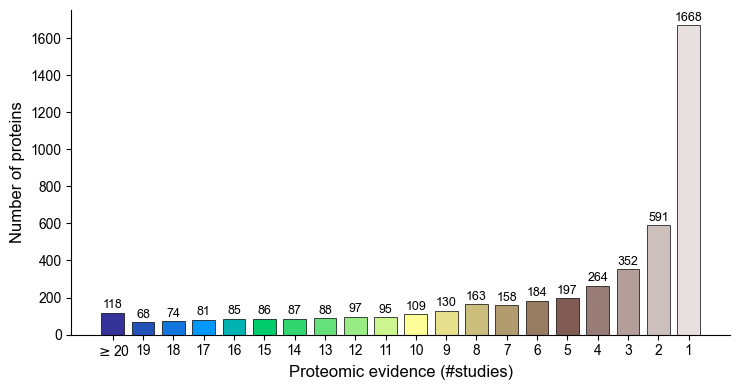

In [16]:
fig, ax_barchart = plt.subplots(1, 1, figsize=(7.5, 4))
sns.despine(ax=ax_barchart)

df_total_proteins = df_value_counts_colors["Total"]
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize=fontsize - 3
)
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
all_figure_data["ProteomicEvidenceSummary"] = df_total_proteins.copy()

fig.tight_layout()
if overwrite:
    fig.savefig(
        f"{results_path}/AllProteomicEvidence_PanelB.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig;

### Aggregate Panels for visualization

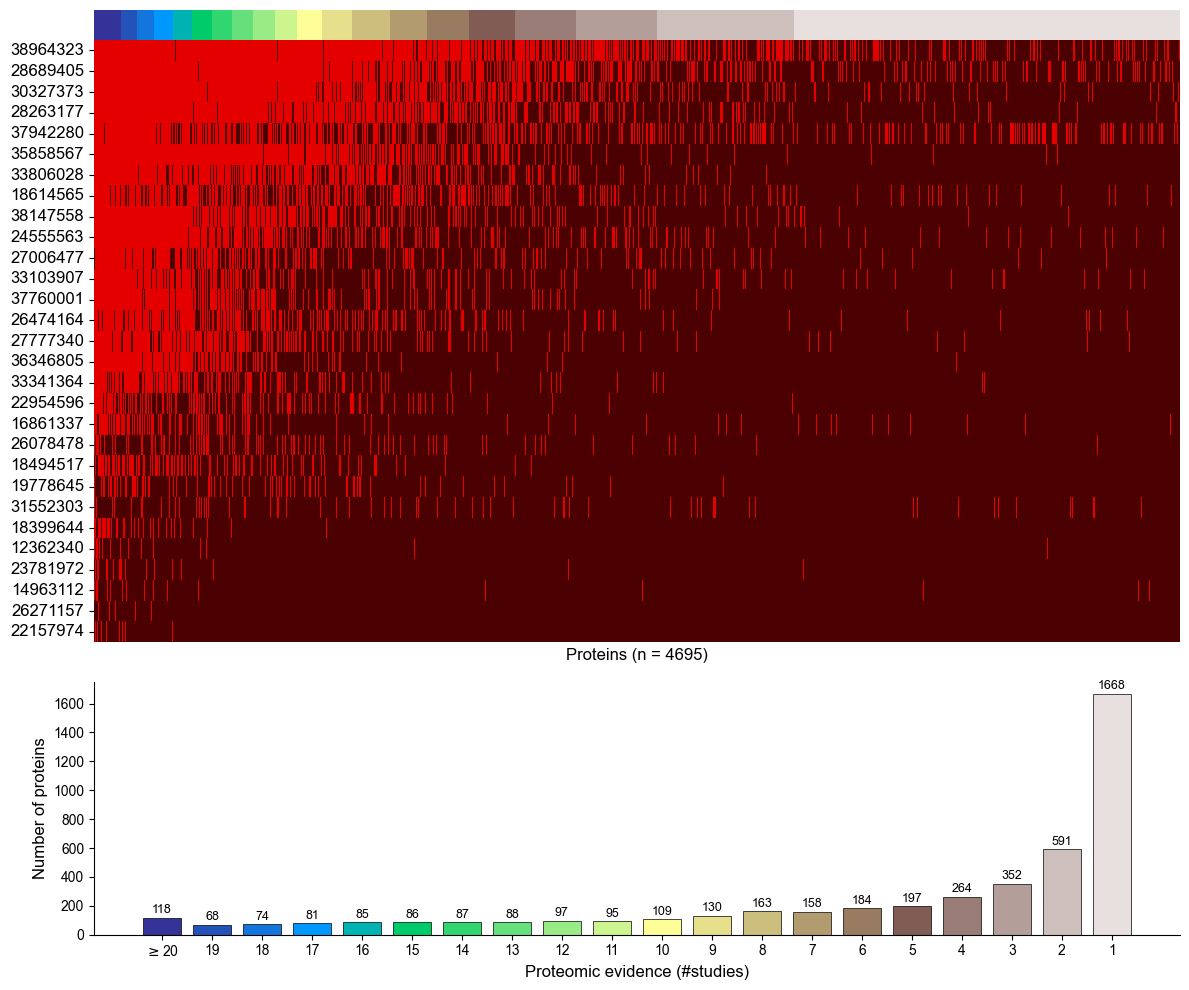

In [17]:
fig = mpl.figure.Figure(figsize=(12, 10))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1, 0.4])
sgs = mpl.gridspec.GridSpecFromSubplotSpec(
    2, 1, hspace=0, height_ratios=[0.05, 1], subplot_spec=gs[0]
)

has_additional_evidence_color, no_additional_evidence_color = (
    mpl.colors.to_rgba_array("xkcd:dark grey"),
    np.array([x / 2 + 0.5 for x in mpl.colors.to_rgba_array("xkcd:light grey")]),
)

df_proteomic_cmap = df_figure_data.sum()
df_proteomic_cmap = df_proteomic_cmap.apply(lambda x: x if x < max_count else max_count)
df_proteomic_cmap = np.array([df_proteomic_cmap.values])

# Add col colors (similar to seaborn)
cmap_dict = df_value_counts_colors["Colors"].to_dict()
cmap_segmented = mpl.colors.LinearSegmentedColormap.from_list(
    "legend", [cmap_dict[c] for c in df_value_counts_colors.index[::-1]], len(cmap_dict)
)

ax_nstudies_colors = sns.heatmap(
    df_proteomic_cmap,
    ax=fig.add_subplot(sgs[0]),
    xticklabels=False,
    yticklabels=False,
    cmap=cmap_segmented,
    cbar=False,
)

# Heatmap
ax_heatmap = sns.heatmap(
    df_figure_data.rename(
        {row: row.lstrip("pubmed:") for row in df_figure_data.index}, axis=0
    ),
    ax=fig.add_subplot(sgs[1]),
    cbar=False,
    cmap=mpl.colors.ListedColormap(["xkcd:dried blood", "xkcd:red"]),
    xticklabels=False,
)
ax_heatmap.set_xlabel(None)
ax_heatmap.set_ylabel(None)
ax_heatmap.yaxis.tick_left()
ax_heatmap.tick_params(axis="y", labelsize=fontsize)
ax_heatmap.set_xlabel(
    f"Proteins (n = {len(df_figure_data.columns)})", fontsize=fontsize
)

# Barchart
ax_barchart = fig.add_subplot(gs[1])
sns.despine(ax=ax_barchart)

df_total_proteins = df_value_counts_colors["Total"]
rects = ax_barchart.bar(
    df_total_proteins.index,
    df_total_proteins.values,
    bar_size,
    color=df_value_counts_colors["Colors"].values,
    edgecolor=edgecolor,
    linewidth=edgewidth,
)
ax_barchart.bar_label(
    rects, labels=df_total_proteins.values, padding=1, fontsize=fontsize - 3
)
ax_barchart.set_xlabel(df_value_counts_colors.index.name, fontsize=fontsize)
ax_barchart.set_ylabel(f"Number of proteins", fontsize=fontsize)
fig.tight_layout()
if overwrite:
    fig.savefig(
        f"{results_path}/AllProteomicEvidence_PanelAB.{imagetype}",
        transparent=transparent,
        format=imagetype,
    )
fig

## Export Figures and Data

In [18]:
print(all_figure_data.keys())
if overwrite:
    with pd.ExcelWriter(f"{results_path}/AllProteomicsData.xlsx") as writer:
        for sheet_name, df in all_figure_data.items():
            df = df.T.reset_index(drop=False)
            df.to_excel(writer, sheet_name=sheet_name, index=False)

dict_keys(['ProteomicEvidenceAll', 'ProteomicEvidenceSummary'])


#### Look up specific protein
Paste a list of UniProt Identifiers into the string to look up how many times those proteins were detected

In [58]:
plist = """
Q9UQ10
""".strip().split(
    "\n"
)
df = df_figure_data.T
df = df[df.index.isin(plist)]

# df[df > 10]
print(df.T)
df = df.sum(axis=1)
# df = df[df <= 20]
# df = df[df >= 15]
for x in df.index:
    print(x)
df

Uniprot          Q9UQ10
pubmed                 
pubmed:38964323       0
pubmed:28689405       0
pubmed:30327373       0
pubmed:28263177       0
pubmed:37942280       0
pubmed:35858567       0
pubmed:33806028       0
pubmed:18614565       0
pubmed:38147558       0
pubmed:24555563       0
pubmed:27006477       0
pubmed:33103907       0
pubmed:37760001       0
pubmed:26474164       0
pubmed:27777340       0
pubmed:36346805       0
pubmed:33341364       0
pubmed:22954596       0
pubmed:16861337       1
pubmed:26078478       0
pubmed:18494517       0
pubmed:19778645       0
pubmed:31552303       0
pubmed:18399644       0
pubmed:12362340       0
pubmed:23781972       0
pubmed:14963112       0
pubmed:26271157       0
pubmed:22157974       0
Q9UQ10


Uniprot
Q9UQ10    1
dtype: int64

#### Example
Example given is for removed proteins.

In [20]:
plist = """
Q5T3U5
Q08828
O60266
Q8NFM4
O95622
O43306
P51828
P40145
O60503
O15120
Q9NUQ2
O94788
P17707
Q06278
Q9UN42
Q92903
Q9Y6K0
P35790
Q9Y259
Q8WUD6
Q05315
Q86VU5
P36551
P23786
Q9Y6T7
Q16760
P52429
P49619
Q86XP1
O75912
P52824
Q13574
P22413
Q9HBU6
Q9NVF9
P09467
O00757
P22830
P32189
Q14410
Q14409
Q9HCL2
Q86UL3
P09210
P33402
O75343
P25092
Q02846
P51841
P52789
Q2TB90
P09601
P30519
P20839
P23677
P27987
Q96DU7
Q9UHV8
Q00266
O95544
O75414
Q9Y5B8
Q9NWW6
P16066
P20594
O14841
Q9Y233
Q9HCR9
Q01064
Q14123
P27815
Q07343
Q08493
Q13946
Q9NP56
O60658
O95263
P16118
O60825
Q16875
Q16877
Q9UBF8
Q9Y2I7
O14986
P14555
O60733
O14494
O43688
O14495
P50336
P51606
Q9H310
O15244
O75751
Q14542
Q9BYW1
Q6PXP3
Q9NY64
Q9H2H9
Q96QD8
Q969I6
P13866
P53794
Q92911
Q9GZV3
Q9UN76
P52569
Q8WY07
Q9Y6L6
Q9NPD5
P17735
O60701
P22309
P22310
Q8TF68
""".strip().split(
    "\n"
)
df = df_figure_data.T
df = df[df.index.isin(plist)]
for x in df.index:
    print(x)
# df[df > 10]
df.sum(axis=1)

P36551
Q05315
P22830
P52569
Q9Y5B8
O14841
O14494
Q5T3U5
Q16760
Q14123
Q07343
P09210
P09601
Q96QD8
P23786


Uniprot
P36551    7
Q05315    5
P22830    5
P52569    2
Q9Y5B8    1
O14841    1
O14494    1
Q5T3U5    1
Q16760    1
Q14123    1
Q07343    1
P09210    1
P09601    1
Q96QD8    1
P23786    1
dtype: int64